In [2]:
import numpy as np
import networkx as nx
from default_architecture_class import default_arhitecture
from default_architecture_class import arhitecture_specs
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from gates import AndGate, OrGate, XorGate, NandGate, BitPhaseEncoder
from Multiplier import Multiplier2x2

In [98]:
#lambdas = np.array([3,5,7])
#x_values = np.array([0,1,2])

#spec = arhitecture_specs(M=3, m0=2, S=3, lambdas=lambdas, x_values=x_values, M = )
#arch = default_arhitecture(spec)


def draw_architecture(G, figsize=(14, 6), label_shift=0.25):
    cmap = cm.get_cmap("tab10")
    stages = {}
    for n, data in G.nodes(data=True):
        stage = data.get("stage")
        stages.setdefault(stage, []).append(n)
    stage_order = ["input_code", "logical_weights", "trig", "decoder", "encoder", "output_code", "unknown"]
    stage_order = [s for s in stage_order if s in stages]

    pos = {}
    for x, s in enumerate(stage_order):
        nodes = sorted(stages[s])
        for idx, n in enumerate(nodes):
            pos[n] = (x, -idx)
    
    stage_to_color = {s: i for i, s in enumerate(stage_order)}
    node_colors = [stage_to_color[G.nodes[n].get("stage")] for n in G.nodes()]

    plt.figure(figsize=figsize)

    # edges (with arrows)
    nx.draw_networkx_edges(
        G, pos,
        arrows=True,
        arrowstyle='-|>',
        arrowsize=12,
        width=1.0,
        alpha=0.35,
        connectionstyle="arc3,rad=0.0"
    )

    # nodes
    nx.draw_networkx_nodes(
    G, pos,
    node_color=node_colors,
    cmap=cmap,
    vmin=0,
    vmax=max(stage_to_color.values()) if stage_to_color else 1,
    node_size=350,
    linewidths=0.8
)

    labels = {n: n for n in G.nodes()}
    label_pos = {n: (pos[n][0], pos[n][1] - label_shift) for n in G.nodes()}
    nx.draw_networkx_labels(G, label_pos, labels=labels, font_size=7)

    edge_labels = {
            (u, v): data["weight"]
            for u, v, data in G.edges(data=True)
            if data.get("weight") is not None
        }
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=7, label_pos=0.5)

    cmap = cm.get_cmap("tab10")

    plt.axis("off")
    plt.tight_layout()
    plt.show()


C:\Users\yusuf\AppData\Local\Temp\ipykernel_16348\2038560003.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("tab10")
C:\Users\yusuf\AppData\Local\Temp\ipykernel_16348\2038560003.py:61: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("tab10")


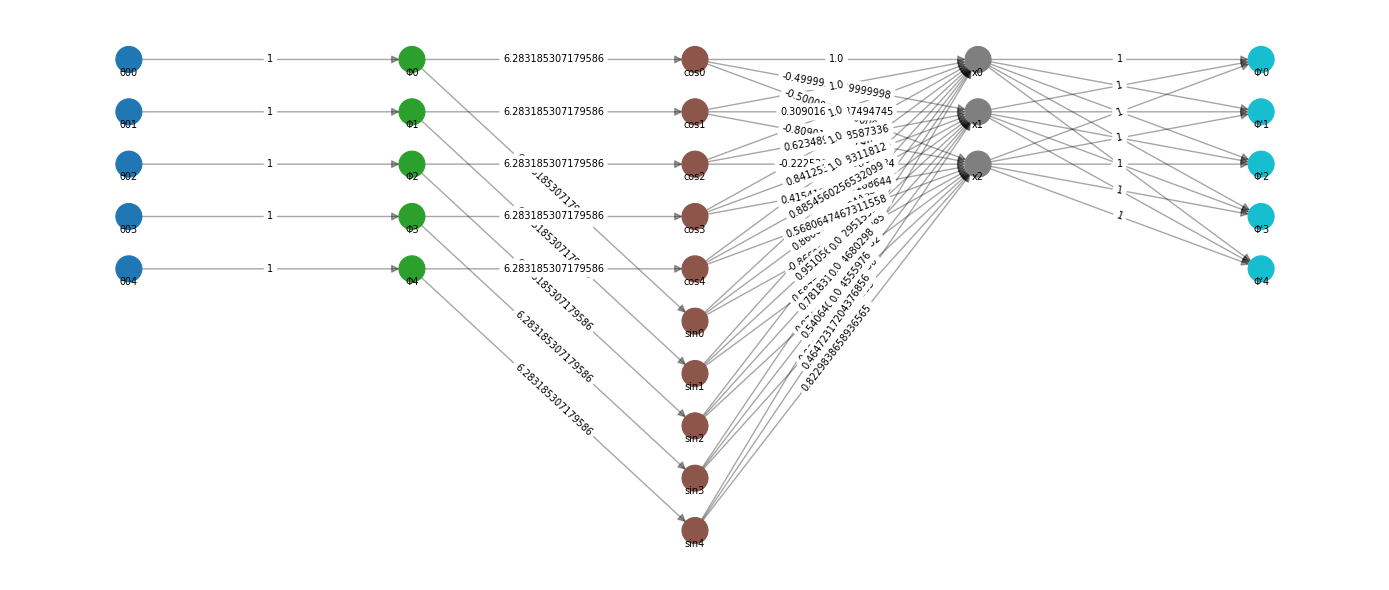

In [100]:
G = arch.graph()   # or whatever you called it
draw_architecture(G)

In [102]:
def decode_phases(out_phases, x_values, lambdas):
    out_phases = np.asarray(out_phases, dtype=float)
    x_values = np.asarray(x_values, dtype=float)
    lambdas = np.asarray(lambdas, dtype=float)

    scores = []
    for xk in x_values:
        acc = 0.0
        for j in range(len(lambdas)):
            acc += np.cos(2*np.pi*(out_phases[j] - xk/lambdas[j]))
        scores.append(acc)

    k_hat = int(np.argmax(scores))
    return x_values[k_hat], np.array(scores)


### Gate testing

In [2]:
lambdas = np.array([3, 5, 7])
x_values = np.array([0.0, 1.0, 2.0])
spec = arhitecture_specs(M=3, m0=2, S=3, lambdas=lambdas, x_values=x_values)
gate = NandGate(spec, sigma_phase=0.0, sigma_trig=0.0, sigma_score=0.0, p=0.0, logical_weights=[1, 1])
def encode_y_to_phases(y: float, lambdas: np.ndarray) -> np.ndarray:
        return (y / lambdas) % 1.0

# Inputs: (1,1) -> sum=2 -> AND=1
theta = np.vstack([
    encode_y_to_phases(0.0, spec.lambdas),
    encode_y_to_phases(0.0, spec.lambdas),
])
out = gate.forward(theta)

print("decoded k_hat:", out["k_hat"], "decoded x_k:", spec.x_values[out["k_hat"]])
print("out_phases:", out["out_phases"])

y_hat = decode_phases(
        out["out_phases"],
        spec.x_values,
        spec.lambdas
)
print(y_hat[0])

decoded k_hat: 0 decoded x_k: 0.0
out_phases: [0.33333333 0.2        0.14285714]


NameError: name 'decode_phases' is not defined

### Multiplier testing

In [3]:
spec = arhitecture_specs(
    M=5,
    m0=2,
    S=3,
    lambdas=np.array([3, 5, 7, 11, 13], dtype=float),
    x_values=np.array([0.0, 1.0, 2.0], dtype=float),
)

# --- 2) Build multiplier
mult = Multiplier2x2(spec)

# --- 3) Input numbers (2-bit each)
A = 3   # binary 10
B = 1   # binary 11

# split into bits
a1, a0 = (A >> 1) & 1, A & 1
b1, b0 = (B >> 1) & 1, B & 1

# --- 4) Run multiplier
out = mult.forward_bits(a1, a0, b1, b0)

# --- 5) Decode output bits (simple nearest check)
def decode_bit(phases, lambdas):
    lambdas = np.asarray(lambdas, float)
    proto0 = np.zeros_like(lambdas)
    proto1 = (1.0 / lambdas) % 1.0
    d0 = np.sum(np.abs(phases - proto0))
    d1 = np.sum(np.abs(phases - proto1))
    return 0 if d0 < d1 else 1

p0 = decode_bit(out["p0"], spec.lambdas)
p1 = decode_bit(out["p1"], spec.lambdas)
p2 = decode_bit(out["p2"], spec.lambdas)
p3 = decode_bit(out["p3"], spec.lambdas)

# --- 6) Result
product = (p3 << 3) | (p2 << 2) | (p1 << 1) | p0

print(f"A = {A} ({a1}{a0})")
print(f"B = {B} ({b1}{b0})")
print(f"Result bits = {p3}{p2}{p1}{p0}")
print(f"Result = {product}")

A = 3 (11)
B = 1 (01)
Result bits = 0011
Result = 3


In [4]:
lambdas = [3, 5, 7, 11, 13]
encNN = BitPhaseEncoder(M=len(lambdas), lambdas=lambdas)

ph0 = encNN.forward_bit(0)
ph1 = encNN.forward_bit(1)

print("bit 0 phases:", ph0)
print("bit 1 phases:", ph1)

bit 0 phases: [0. 0. 0. 0. 0.]
bit 1 phases: [0.33333333 0.2        0.14285714 0.09090909 0.07692308]


In [5]:
enc = BitPhaseEncoder(M=5, lambdas=[3,5,7,11,13])
print("Encoder weights (x_k → Φ'_j):")
for u, v, d in enc.G.edges(data=True):
    if u.startswith("x") and v.startswith("Φ'"):
        print(f"{u} -> {v} : {d['weight']}")


Encoder weights (x_k → Φ'_j):
x0 -> Φ'0 : 0.0
x0 -> Φ'1 : 0.0
x0 -> Φ'2 : 0.0
x0 -> Φ'3 : 0.0
x0 -> Φ'4 : 0.0
x1 -> Φ'0 : 0.3333333333333333
x1 -> Φ'1 : 0.2
x1 -> Φ'2 : 0.14285714285714285
x1 -> Φ'3 : 0.09090909090909091
x1 -> Φ'4 : 0.07692307692307693


In [6]:
x_values = np.array([0.0,1.0,2.0])

In [7]:
gate_spec = arhitecture_specs(
    M=5, m0=2, S=3,
    lambdas=np.array([3,5,7,11,13], float),
    x_values=np.array([0.0,1.0,2.0], float),
)

mult = Multiplier2x2(gate_spec)

# A=2 (10), B=3 (11)
out = mult.forward_bits(a1=1, a0=0, b1=1, b0=1)
print(out["p3"], out["p2"], out["p1"], out["p0"])

[0. 0. 0. 0. 0.] [0.33333333 0.2        0.14285714 0.09090909 0.07692308] [0.33333333 0.2        0.14285714 0.09090909 0.07692308] [0. 0. 0. 0. 0.]


In [8]:
out["p3"]

array([0., 0., 0., 0., 0.])

In [120]:
decode_phases(out["p3"], x_values=x_values, lambdas=np.array([3, 5, 7, 11, 13]))

(0.0, array([ 5.        ,  2.15921635, -0.54805817]))

In [122]:
print(decode_bit(out["p3"], lambdas=np.array([3,5,7,11,13], float)), decode_bit(out["p2"], lambdas=np.array([3,5,7,11,13], float)), decode_bit(out["p1"], lambdas=np.array([3,5,7,11,13], float)), decode_bit(out["p0"], lambdas=np.array([3,5,7,11,13], float)))

0 1 1 0


# PLOT

In [9]:
import numpy as np
import matplotlib.pyplot as plt

from gates import AndGate
from gates import BitPhaseEncoder
from default_architecture_class import arhitecture_specs


In [3]:
M = 7
lambdas = np.array([3, 4, 5, 7, 11, 13, 17], dtype=float)

spec = arhitecture_specs(
    M=M,
    m0=2,              # two-input gate
    S=3,               # decoded sums: {0,1,2}
    lambdas=lambdas,
    x_values=np.array([0.0, 1.0, 2.0])
)

In [11]:
def decode_bit(out_phases, lambdas):
    scores = []
    for x in [0.0, 1.0]:
        score = 0.0
        for j in range(len(lambdas)):
            angle = 2 * np.pi * (x / lambdas[j])
            score += np.cos(2*np.pi*out_phases[j] - angle)
        scores.append(score)
    return int(np.argmax(scores))


In [12]:
def estimate_and_error(
    gate = "And",
    sigma_phase=0.0,
    sigma_trig=0.0,
    sigma_score=0.0,
    p=0.0,
    trials=2000,
):
    errors = 0

    if gate == "And":
        func = AndGate(
            spec,
            sigma_phase=sigma_phase,
            sigma_trig=sigma_trig,
            sigma_score=sigma_score,
            p=p,
        )

    elif gate == "Or":
        func = OrGate(
            spec,
            sigma_phase=sigma_phase,
            sigma_trig=sigma_trig,
            sigma_score=sigma_score,
            p=p,
        )

    elif gate == "Xor":
        func = XorGate(
            spec,
            sigma_phase=sigma_phase,
            sigma_trig=sigma_trig,
            sigma_score=sigma_score,
            p=p,
        )

    elif gate == "Nand":
        func = NandGate(
            spec,
            sigma_phase=sigma_phase,
            sigma_trig=sigma_trig,
            sigma_score=sigma_score,
            p=p,
        )


    
    enc = BitPhaseEncoder(
        M,
        lambdas,
        sigma_phase=sigma_phase,
        sigma_trig=sigma_trig,
        sigma_score=sigma_score,
        p=p,
    )

    for _ in range(trials):
        a = np.random.randint(0, 2)
        b = np.random.randint(0, 2)

        A = enc.forward_bit(a)
        B = enc.forward_bit(b)

        out = func.forward(np.vstack([A, B]))["out_phases"]
        y_hat = decode_bit(out, lambdas)

        if y_hat != (a & b):
            errors += 1

    return errors / trials



In [13]:
def estimate_and_error(
    gate = "And", # renamed from 'gate' to avoid confusion with the object
    sigma_phase=0.0,
    sigma_trig=0.0,
    sigma_score=0.0,
    p=0.0,
    trials=2000,
):
    errors = 0
    
    # Mapping gate strings to Classes and Logic
    gate_map = {
        "And": (AndGate, lambda a, b: a & b),
        "Or":  (OrGate,  lambda a, b: a | b),
        "Xor": (XorGate, lambda a, b: a ^ b),
        "Nand": (NandGate, lambda a, b: int(not (a & b)))
    }
    
    if gate not in gate_map:
        raise ValueError(f"Gate {gate} not recognized")
        
    gate_class, logic_op = gate_map[gate]

    # Instantiate the gate
    func = gate_class(
        spec,
        sigma_phase=sigma_phase,
        sigma_trig=sigma_trig,
        sigma_score=sigma_score,
        p=p,
    )
    
    enc = BitPhaseEncoder(M, lambdas, sigma_phase=sigma_phase, 
                          sigma_trig=sigma_trig, sigma_score=sigma_score, p=p)

    for _ in range(trials):
        a = np.random.randint(0, 2)
        b = np.random.randint(0, 2)

        A = enc.forward_bit(a)
        B = enc.forward_bit(b)

        out = func.forward(np.vstack([A, B]))["out_phases"]
        y_hat = decode_bit(out, lambdas)

        # FIXED: use the logic_op associated with the gate_type
        if y_hat != logic_op(a, b):
            errors += 1

    return errors / trials

# AND

In [12]:
sigmas = np.linspace(0.0, 0.5, 12)
error_rates = []

for s in sigmas:
    err = estimate_and_error(
        gate = "And",
        sigma_phase=s,
        sigma_trig=0.0,
        sigma_score=0.0,
        p=0.0,
        trials=3000,
    )
    error_rates.append(err)
    print(f"sigma_phase={s:.3f}, error={err:.4f}")


sigma_phase=0.000, error=0.0000
sigma_phase=0.045, error=0.0060
sigma_phase=0.091, error=0.1677
sigma_phase=0.136, error=0.3820
sigma_phase=0.182, error=0.4413
sigma_phase=0.227, error=0.4567
sigma_phase=0.273, error=0.4740
sigma_phase=0.318, error=0.4937
sigma_phase=0.364, error=0.4897
sigma_phase=0.409, error=0.4877
sigma_phase=0.455, error=0.5210
sigma_phase=0.500, error=0.4950


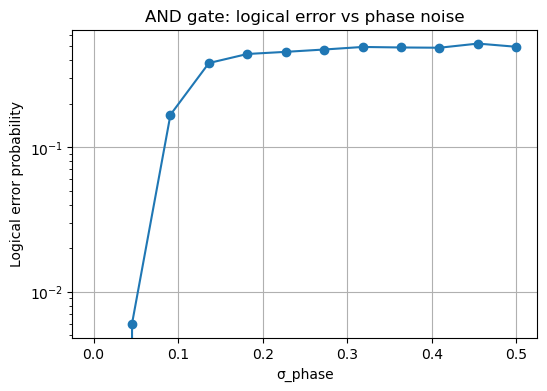

In [13]:
plt.figure(figsize=(6,4))
plt.plot(sigmas, error_rates, marker="o")
plt.xlabel("σ_phase")
plt.ylabel("Logical error probability")
plt.title("AND gate: logical error vs phase noise")
plt.yscale("log")
plt.grid(True)
plt.show()


In [27]:
sigma_trigs = np.linspace(0.273, 6, 20)
error_trig = []

for s in sigma_trigs:
    err = estimate_and_error(
        sigma_phase=0.0,
        sigma_trig=s,
        sigma_score=0.0,
        p=0.0,
        trials=3000,
    )
    error_trig.append(err)
    print(f"sigma_trig={s:.3f}, error={err:.4f}")


sigma_trig=0.273, error=0.0000
sigma_trig=0.574, error=0.0140
sigma_trig=0.876, error=0.0863
sigma_trig=1.177, error=0.1867
sigma_trig=1.479, error=0.2427
sigma_trig=1.780, error=0.2983
sigma_trig=2.082, error=0.3113
sigma_trig=2.383, error=0.3637
sigma_trig=2.684, error=0.3623
sigma_trig=2.986, error=0.3813
sigma_trig=3.287, error=0.3810
sigma_trig=3.589, error=0.3963
sigma_trig=3.890, error=0.3933
sigma_trig=4.191, error=0.4037
sigma_trig=4.493, error=0.3867
sigma_trig=4.794, error=0.4123
sigma_trig=5.096, error=0.4087
sigma_trig=5.397, error=0.4287
sigma_trig=5.699, error=0.4210
sigma_trig=6.000, error=0.4213


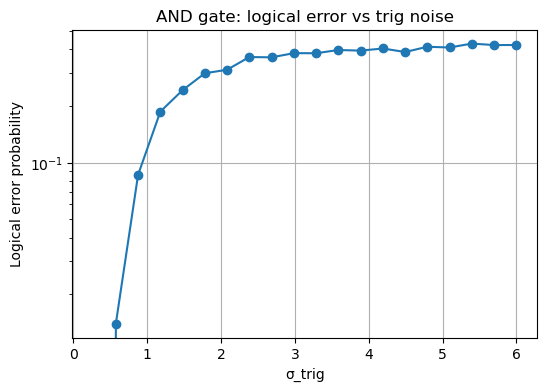

In [28]:
plt.figure(figsize=(6,4))
plt.plot(sigma_trigs, error_trig, marker="o")
plt.xlabel("σ_trig")
plt.ylabel("Logical error probability")
plt.title("AND gate: logical error vs trig noise")
plt.yscale("log")
plt.grid(True)
plt.show()


In [33]:
sigma_scores = np.linspace(0.0, 14, 20)
error_score = []

for s in sigma_scores:
    err = estimate_and_error(
        sigma_phase=0.0,
        sigma_trig=0.0,
        sigma_score=s,
        p=0.0,
        trials=3000,
    )
    error_score.append(err)
    print(f"sigma_score={s:.3f}, error={err:.4f}")


sigma_score=0.000, error=0.0000
sigma_score=0.737, error=0.0000
sigma_score=1.474, error=0.0560
sigma_score=2.211, error=0.1447
sigma_score=2.947, error=0.2303
sigma_score=3.684, error=0.2890
sigma_score=4.421, error=0.3050
sigma_score=5.158, error=0.3110
sigma_score=5.895, error=0.3533
sigma_score=6.632, error=0.3627
sigma_score=7.368, error=0.3643
sigma_score=8.105, error=0.3647
sigma_score=8.842, error=0.3717
sigma_score=9.579, error=0.4007
sigma_score=10.316, error=0.4093
sigma_score=11.053, error=0.4073
sigma_score=11.789, error=0.3877
sigma_score=12.526, error=0.3847
sigma_score=13.263, error=0.4087
sigma_score=14.000, error=0.4073


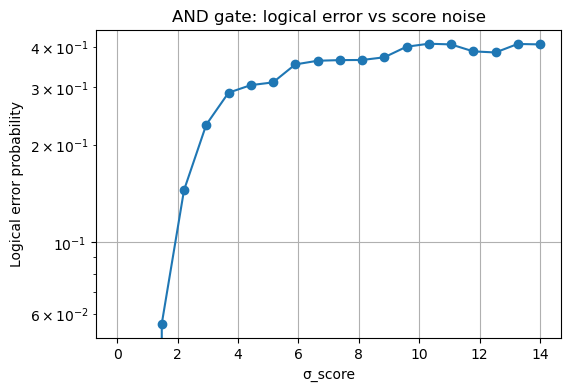

In [34]:
plt.figure(figsize=(6,4))
plt.plot(sigma_scores, error_score, marker="o")
plt.xlabel("σ_score")
plt.ylabel("Logical error probability")
plt.title("AND gate: logical error vs score noise")
plt.yscale("log")
plt.grid(True)
plt.show()


In [18]:
ps = np.linspace(0.0, 0.5, 11)
error_p = []

for p_val in ps:
    err = estimate_and_error(
        sigma_phase=0.0,
        sigma_trig=0.0,
        sigma_score=0.0,
        p=p_val,
        trials=3000,
    )
    error_p.append(err)
    print(f"p={p_val:.3f}, error={err:.4f}")


p=0.000, error=0.0000
p=0.050, error=0.0273
p=0.100, error=0.0813
p=0.150, error=0.1623
p=0.200, error=0.1967
p=0.250, error=0.2167
p=0.300, error=0.2347
p=0.350, error=0.2517
p=0.400, error=0.2523
p=0.450, error=0.2493
p=0.500, error=0.2487


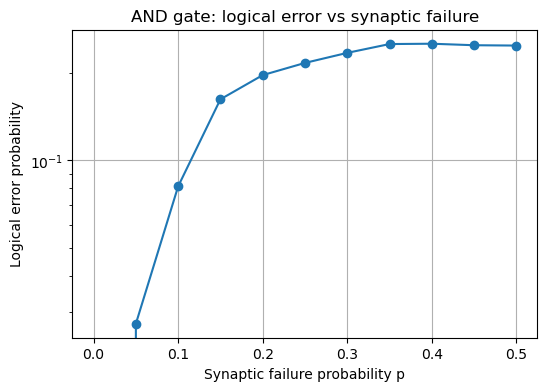

In [19]:
plt.figure(figsize=(6,4))
plt.plot(ps, error_p, marker="o")
plt.xlabel("Synaptic failure probability p")
plt.ylabel("Logical error probability")
plt.title("AND gate: logical error vs synaptic failure")
plt.yscale("log")
plt.grid(True)
plt.show()


# OR

In [20]:
sigmas = np.linspace(0.0, 0.5, 12)
error_rates = []

for s in sigmas:
    err = estimate_and_error(
        gate = "Or",
        sigma_phase=s,
        sigma_trig=0.0,
        sigma_score=0.0,
        p=0.0,
        trials=3000,
    )
    error_rates.append(err)
    print(f"sigma_phase={s:.3f}, error={err:.4f}")

sigma_phase=0.000, error=0.0000
sigma_phase=0.045, error=0.0050
sigma_phase=0.091, error=0.1637
sigma_phase=0.136, error=0.3537
sigma_phase=0.182, error=0.4557
sigma_phase=0.227, error=0.4573
sigma_phase=0.273, error=0.4763
sigma_phase=0.318, error=0.4740
sigma_phase=0.364, error=0.4947
sigma_phase=0.409, error=0.4850
sigma_phase=0.455, error=0.4843
sigma_phase=0.500, error=0.5120


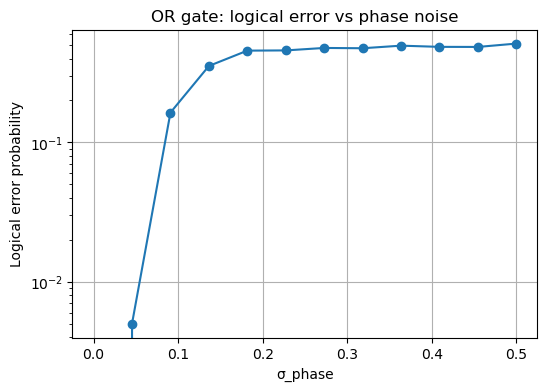

In [21]:
plt.figure(figsize=(6,4))
plt.plot(sigmas, error_rates, marker="o")
plt.xlabel("σ_phase")
plt.ylabel("Logical error probability")
plt.title("OR gate: logical error vs phase noise")
plt.yscale("log")
plt.grid(True)
plt.show()


In [22]:
sigma_trigs = np.linspace(0.0, 1, 12)
error_trig = []

for s in sigma_trigs:
    err = estimate_and_error(
        gate = "Or",
        sigma_phase=0.0,
        sigma_trig=s,
        sigma_score=0.0,
        p=0.0,
        trials=3000,
    )
    error_trig.append(err)
    print(f"sigma_trig={s:.3f}, error={err:.4f}")


sigma_trig=0.000, error=0.0000
sigma_trig=0.091, error=0.0000
sigma_trig=0.182, error=0.0000
sigma_trig=0.273, error=0.0000
sigma_trig=0.364, error=0.0003
sigma_trig=0.455, error=0.0013
sigma_trig=0.545, error=0.0103
sigma_trig=0.636, error=0.0227
sigma_trig=0.727, error=0.0467
sigma_trig=0.818, error=0.0683
sigma_trig=0.909, error=0.1170
sigma_trig=1.000, error=0.1340


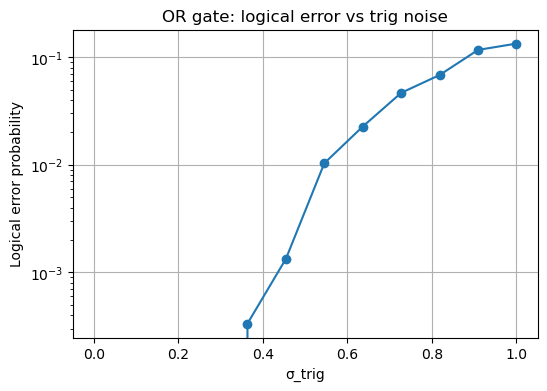

In [23]:
plt.figure(figsize=(6,4))
plt.plot(sigma_trigs, error_trig, marker="o")
plt.xlabel("σ_trig")
plt.ylabel("Logical error probability")
plt.title("OR gate: logical error vs trig noise")
plt.yscale("log")
plt.grid(True)
plt.show()


In [24]:
sigma_scores = np.linspace(0.0, 2, 12)
error_score = []

for s in sigma_scores:
    err = estimate_and_error(
        gate = "Or",
        sigma_phase=0.0,
        sigma_trig=0.0,
        sigma_score=s,
        p=0.0,
        trials=3000,
    )
    error_score.append(err)
    print(f"sigma_score={s:.3f}, error={err:.4f}")


sigma_score=0.000, error=0.0000
sigma_score=0.182, error=0.0000
sigma_score=0.364, error=0.0000
sigma_score=0.545, error=0.0000
sigma_score=0.727, error=0.0003
sigma_score=0.909, error=0.0017
sigma_score=1.091, error=0.0123
sigma_score=1.273, error=0.0233
sigma_score=1.455, error=0.0403
sigma_score=1.636, error=0.0680
sigma_score=1.818, error=0.0977
sigma_score=2.000, error=0.1290


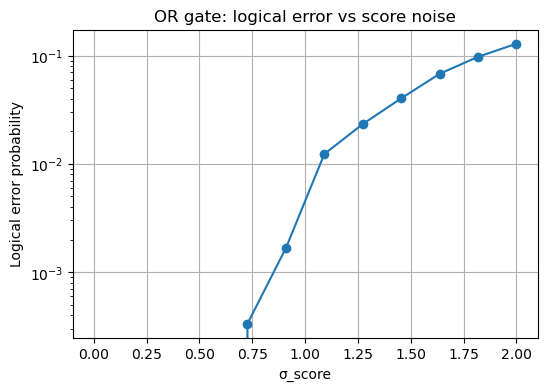

In [25]:
plt.figure(figsize=(6,4))
plt.plot(sigma_scores, error_score, marker="o")
plt.xlabel("σ_score")
plt.ylabel("Logical error probability")
plt.title("OR gate: logical error vs score noise")
plt.yscale("log")
plt.grid(True)
plt.show()


In [26]:
ps = np.linspace(0.0, 0.5, 11)
error_p = []

for p_val in ps:
    err = estimate_and_error(
        gate = "Or",
        sigma_phase=0.0,
        sigma_trig=0.0,
        sigma_score=0.0,
        p=p_val,
        trials=3000,
    )
    error_p.append(err)
    print(f"p={p_val:.3f}, error={err:.4f}")


p=0.000, error=0.0000
p=0.050, error=0.0207
p=0.100, error=0.0883
p=0.150, error=0.1910
p=0.200, error=0.3047
p=0.250, error=0.3873
p=0.300, error=0.4850
p=0.350, error=0.5630
p=0.400, error=0.6027
p=0.450, error=0.6310
p=0.500, error=0.6890


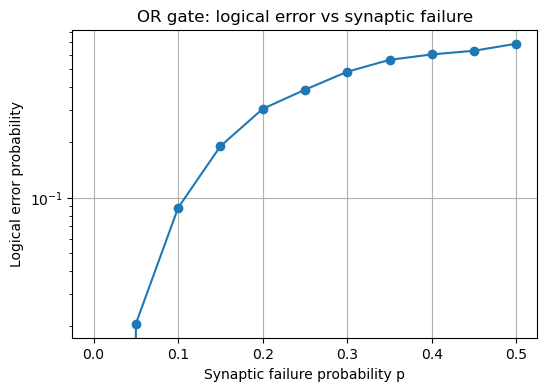

In [27]:
plt.figure(figsize=(6,4))
plt.plot(ps, error_p, marker="o")
plt.xlabel("Synaptic failure probability p")
plt.ylabel("Logical error probability")
plt.title("OR gate: logical error vs synaptic failure")
plt.yscale("log")
plt.grid(True)
plt.show()


# XOR

In [28]:
sigmas = np.linspace(0.0, 0.5, 12)
error_rates = []

for s in sigmas:
    err = estimate_and_error(
        gate = "Xor",
        sigma_phase=s,
        sigma_trig=0.0,
        sigma_score=0.0,
        p=0.0,
        trials=3000,
    )
    error_rates.append(err)
    print(f"sigma_phase={s:.3f}, error={err:.4f}")

sigma_phase=0.000, error=0.0000
sigma_phase=0.045, error=0.0127
sigma_phase=0.091, error=0.2637
sigma_phase=0.136, error=0.4637
sigma_phase=0.182, error=0.4890
sigma_phase=0.227, error=0.5133
sigma_phase=0.273, error=0.4983
sigma_phase=0.318, error=0.5097
sigma_phase=0.364, error=0.5060
sigma_phase=0.409, error=0.5103
sigma_phase=0.455, error=0.5020
sigma_phase=0.500, error=0.4827


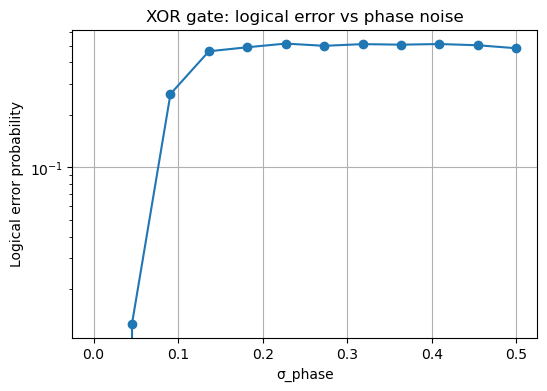

In [29]:
plt.figure(figsize=(6,4))
plt.plot(sigmas, error_rates, marker="o")
plt.xlabel("σ_phase")
plt.ylabel("Logical error probability")
plt.title("XOR gate: logical error vs phase noise")
plt.yscale("log")
plt.grid(True)
plt.show()


In [30]:
sigma_trigs = np.linspace(0.0, 1, 12)
error_trig = []

for s in sigma_trigs:
    err = estimate_and_error(
        gate = "Xor",
        sigma_phase=0.0,
        sigma_trig=s,
        sigma_score=0.0,
        p=0.0,
        trials=3000,
    )
    error_trig.append(err)
    print(f"sigma_trig={s:.3f}, error={err:.4f}")


sigma_trig=0.000, error=0.0000
sigma_trig=0.091, error=0.0000
sigma_trig=0.182, error=0.0000
sigma_trig=0.273, error=0.0000
sigma_trig=0.364, error=0.0010
sigma_trig=0.455, error=0.0030
sigma_trig=0.545, error=0.0217
sigma_trig=0.636, error=0.0487
sigma_trig=0.727, error=0.0927
sigma_trig=0.818, error=0.1393
sigma_trig=0.909, error=0.1797
sigma_trig=1.000, error=0.2330


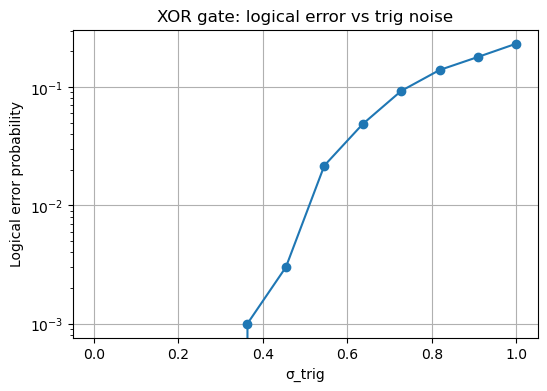

In [31]:
plt.figure(figsize=(6,4))
plt.plot(sigma_trigs, error_trig, marker="o")
plt.xlabel("σ_trig")
plt.ylabel("Logical error probability")
plt.title("XOR gate: logical error vs trig noise")
plt.yscale("log")
plt.grid(True)
plt.show()


In [32]:
sigma_scores = np.linspace(0.0, 2, 12)
error_score = []

for s in sigma_scores:
    err = estimate_and_error(
        gate = "Xor",
        sigma_phase=0.0,
        sigma_trig=0.0,
        sigma_score=s,
        p=0.0,
        trials=3000,
    )
    error_score.append(err)
    print(f"sigma_score={s:.3f}, error={err:.4f}")


sigma_score=0.000, error=0.0000
sigma_score=0.182, error=0.0000
sigma_score=0.364, error=0.0000
sigma_score=0.545, error=0.0000
sigma_score=0.727, error=0.0000
sigma_score=0.909, error=0.0030
sigma_score=1.091, error=0.0180
sigma_score=1.273, error=0.0443
sigma_score=1.455, error=0.0897
sigma_score=1.636, error=0.1340
sigma_score=1.818, error=0.1870
sigma_score=2.000, error=0.2370


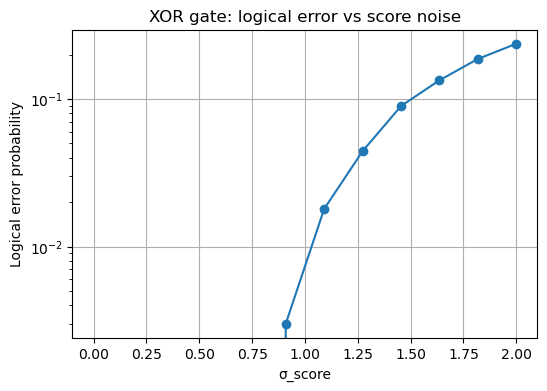

In [33]:
plt.figure(figsize=(6,4))
plt.plot(sigma_scores, error_score, marker="o")
plt.xlabel("σ_score")
plt.ylabel("Logical error probability")
plt.title("XOR gate: logical error vs score noise")
plt.yscale("log")
plt.grid(True)
plt.show()


In [34]:
ps = np.linspace(0.0, 0.5, 11)
error_p = []

for p_val in ps:
    err = estimate_and_error(
        gate = "Xor",
        sigma_phase=0.0,
        sigma_trig=0.0,
        sigma_score=0.0,
        p=p_val,
        trials=3000,
    )
    error_p.append(err)
    print(f"p={p_val:.3f}, error={err:.4f}")


p=0.000, error=0.0000
p=0.050, error=0.0477
p=0.100, error=0.1517
p=0.150, error=0.2860
p=0.200, error=0.3863
p=0.250, error=0.4340
p=0.300, error=0.4610
p=0.350, error=0.4853
p=0.400, error=0.4950
p=0.450, error=0.4987
p=0.500, error=0.4980


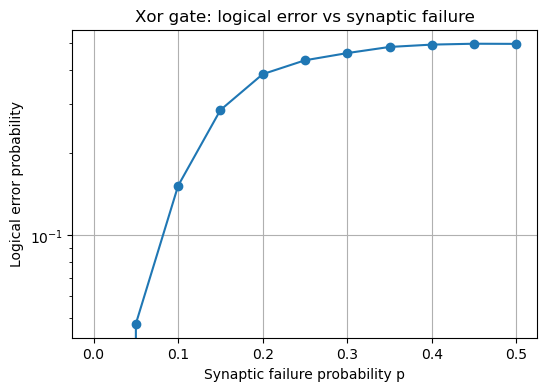

In [35]:
plt.figure(figsize=(6,4))
plt.plot(ps, error_p, marker="o")
plt.xlabel("Synaptic failure probability p")
plt.ylabel("Logical error probability")
plt.title("Xor gate: logical error vs synaptic failure")
plt.yscale("log")
plt.grid(True)
plt.show()


# NAND

In [37]:
sigmas = np.linspace(0.0, 0.5, 20)
error_rates = []

for s in sigmas:
    err = estimate_and_error(
        gate = "Nand",
        sigma_phase=s,
        sigma_trig=0.0,
        sigma_score=0.0,
        p=0.0,
        trials=3000,
    )
    error_rates.append(err)
    print(f"sigma_phase={s:.3f}, error={err:.4f}")

sigma_phase=0.000, error=0.0000
sigma_phase=0.026, error=0.0000
sigma_phase=0.053, error=0.0120
sigma_phase=0.079, error=0.1010
sigma_phase=0.105, error=0.2290
sigma_phase=0.132, error=0.3403
sigma_phase=0.158, error=0.4057
sigma_phase=0.184, error=0.4407
sigma_phase=0.211, error=0.4447
sigma_phase=0.237, error=0.4693
sigma_phase=0.263, error=0.4710
sigma_phase=0.289, error=0.4827
sigma_phase=0.316, error=0.4770
sigma_phase=0.342, error=0.4980
sigma_phase=0.368, error=0.4977
sigma_phase=0.395, error=0.5053
sigma_phase=0.421, error=0.4767
sigma_phase=0.447, error=0.4920
sigma_phase=0.474, error=0.4977
sigma_phase=0.500, error=0.5123


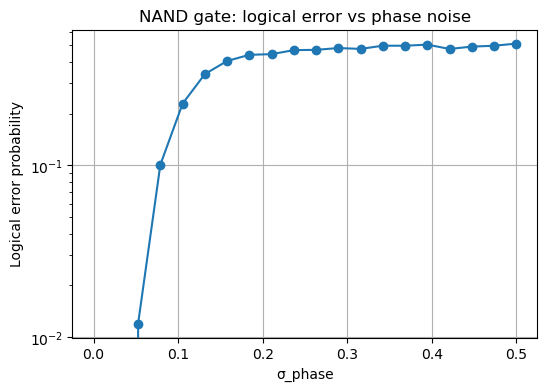

In [38]:
plt.figure(figsize=(6,4))
plt.plot(sigmas, error_rates, marker="o")
plt.xlabel("σ_phase")
plt.ylabel("Logical error probability")
plt.title("NAND gate: logical error vs phase noise")
plt.yscale("log")
plt.grid(True)
plt.show()


In [42]:
sigma_trigs = np.linspace(0.0, 6, 20)
error_trig = []

for s in sigma_trigs:
    err = estimate_and_error(
        gate = "Nand",
        sigma_phase=0.0,
        sigma_trig=s,
        sigma_score=0.0,
        p=0.0,
        trials=3000,
    )
    error_trig.append(err)
    print(f"sigma_trig={s:.3f}, error={err:.4f}")


sigma_trig=0.000, error=0.0000
sigma_trig=0.316, error=0.0000
sigma_trig=0.632, error=0.0237
sigma_trig=0.947, error=0.1163
sigma_trig=1.263, error=0.2067
sigma_trig=1.579, error=0.2653
sigma_trig=1.895, error=0.2973
sigma_trig=2.211, error=0.3473
sigma_trig=2.526, error=0.3573
sigma_trig=2.842, error=0.3793
sigma_trig=3.158, error=0.3733
sigma_trig=3.474, error=0.3960
sigma_trig=3.789, error=0.3747
sigma_trig=4.105, error=0.3923
sigma_trig=4.421, error=0.4000
sigma_trig=4.737, error=0.3907
sigma_trig=5.053, error=0.4080
sigma_trig=5.368, error=0.4090
sigma_trig=5.684, error=0.4147
sigma_trig=6.000, error=0.4173


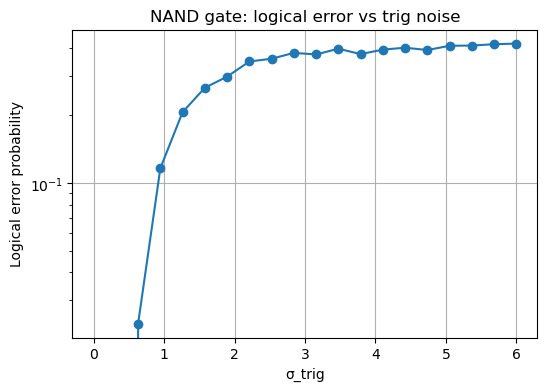

In [43]:
plt.figure(figsize=(6,4))
plt.plot(sigma_trigs, error_trig, marker="o")
plt.xlabel("σ_trig")
plt.ylabel("Logical error probability")
plt.title("NAND gate: logical error vs trig noise")
plt.yscale("log")
plt.grid(True)
plt.show()


In [45]:
sigma_scores = np.linspace(0.0, 8, 20)
error_score = []

for s in sigma_scores:
    err = estimate_and_error(
        gate = "Nand",
        sigma_phase=0.0,
        sigma_trig=0.0,
        sigma_score=s,
        p=0.0,
        trials=3000,
    )
    error_score.append(err)
    print(f"sigma_score={s:.3f}, error={err:.4f}")


sigma_score=0.000, error=0.0000
sigma_score=0.421, error=0.0000
sigma_score=0.842, error=0.0007
sigma_score=1.263, error=0.0240
sigma_score=1.684, error=0.0803
sigma_score=2.105, error=0.1517
sigma_score=2.526, error=0.1863
sigma_score=2.947, error=0.2280
sigma_score=3.368, error=0.2717
sigma_score=3.789, error=0.2930
sigma_score=4.211, error=0.3003
sigma_score=4.632, error=0.3290
sigma_score=5.053, error=0.3293
sigma_score=5.474, error=0.3387
sigma_score=5.895, error=0.3573
sigma_score=6.316, error=0.3597
sigma_score=6.737, error=0.3550
sigma_score=7.158, error=0.3603
sigma_score=7.579, error=0.3827
sigma_score=8.000, error=0.3807


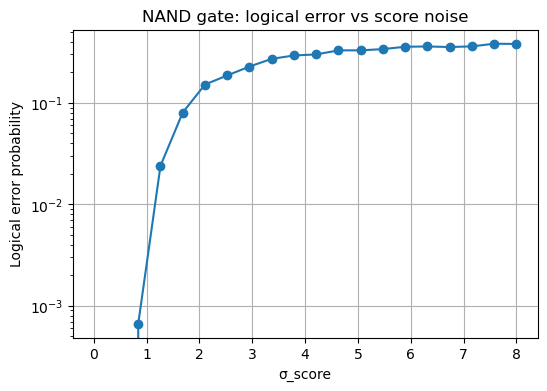

In [46]:
plt.figure(figsize=(6,4))
plt.plot(sigma_scores, error_score, marker="o")
plt.xlabel("σ_score")
plt.ylabel("Logical error probability")
plt.title("NAND gate: logical error vs score noise")
plt.yscale("log")
plt.grid(True)
plt.show()


In [42]:
ps = np.linspace(0.0, 0.5, 11)
error_p = []

for p_val in ps:
    err = estimate_and_error(
        gate = "Nand",
        sigma_phase=0.0,
        sigma_trig=0.0,
        sigma_score=0.0,
        p=p_val,
        trials=3000,
    )
    error_p.append(err)
    print(f"p={p_val:.3f}, error={err:.4f}")


p=0.000, error=0.0000
p=0.050, error=0.0307
p=0.100, error=0.0960
p=0.150, error=0.1690
p=0.200, error=0.2340
p=0.250, error=0.2900
p=0.300, error=0.3360
p=0.350, error=0.3807
p=0.400, error=0.4420
p=0.450, error=0.4530
p=0.500, error=0.4973


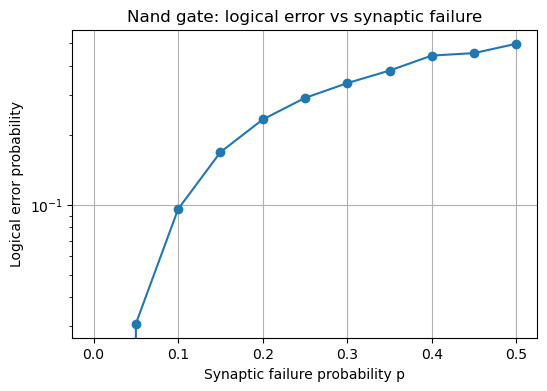

In [43]:
plt.figure(figsize=(6,4))
plt.plot(ps, error_p, marker="o")
plt.xlabel("Synaptic failure probability p")
plt.ylabel("Logical error probability")
plt.title("Nand gate: logical error vs synaptic failure")
plt.yscale("log")
plt.grid(True)
plt.show()


# Multiplier

In [47]:
M = 7
lambdas = np.array([3, 4, 5, 7, 11, 13, 17], dtype=float)

SIGMA_PHASE_BASE = 0.0
SIGMA_TRIG_BASE  = 0.0
SIGMA_SCORE_BASE = 0.0
P_BASE           = 0.0


In [48]:
from Multiplier import Multiplier2x2
from default_architecture_class import arhitecture_specs

def estimate_multiplier_error(
    sigma_phase=0.0,
    sigma_trig=0.0,
    sigma_score=0.0,
    p=0.0,
    trials=6000,
):
    spec = arhitecture_specs(
        M=M,
        m0=2,
        S=3,
        lambdas=lambdas,
        x_values=np.array([0.0, 1.0, 2.0])
    )

    mult = Multiplier2x2(
        spec,
        sigma_phase=sigma_phase,
        sigma_trig=sigma_trig,
        sigma_score=sigma_score,
        p=p,
    )

    errors = 0

    for _ in range(trials):
        a = np.random.randint(0, 4)
        b = np.random.randint(0, 4)

        a1, a0 = (a >> 1) & 1, a & 1
        b1, b0 = (b >> 1) & 1, b & 1

        out = mult.forward_bits(a1, a0, b1, b0)

        p0 = decode_bit(out["p0"], lambdas)
        p1 = decode_bit(out["p1"], lambdas)
        p2 = decode_bit(out["p2"], lambdas)
        p3 = decode_bit(out["p3"], lambdas)

        y_hat  = p0 + (p1 << 1) + (p2 << 2) + (p3 << 3)
        y_true = a * b

        if y_hat != y_true:
            errors += 1

    return errors / trials


In [51]:
sigma_phases = np.linspace(0.0, 0.3, 20)
err_phase = []

for s in sigma_phases:
    err = estimate_multiplier_error(
        sigma_phase=s,
        sigma_trig=SIGMA_TRIG_BASE,
        sigma_score=SIGMA_SCORE_BASE,
        p=P_BASE,
        trials=8000,
    )
    err_phase.append(err)
    print(f"sigma_phase={s:.3f}, error={err:.4f}")


sigma_phase=0.000, error=0.0000
sigma_phase=0.016, error=0.0000
sigma_phase=0.032, error=0.0010
sigma_phase=0.047, error=0.0628
sigma_phase=0.063, error=0.2645
sigma_phase=0.079, error=0.5264
sigma_phase=0.095, error=0.6769
sigma_phase=0.111, error=0.7917
sigma_phase=0.126, error=0.8394
sigma_phase=0.142, error=0.8639
sigma_phase=0.158, error=0.8700
sigma_phase=0.174, error=0.8858
sigma_phase=0.189, error=0.8862
sigma_phase=0.205, error=0.8941
sigma_phase=0.221, error=0.9008
sigma_phase=0.237, error=0.9121
sigma_phase=0.253, error=0.9137
sigma_phase=0.268, error=0.9190
sigma_phase=0.284, error=0.9207
sigma_phase=0.300, error=0.9253


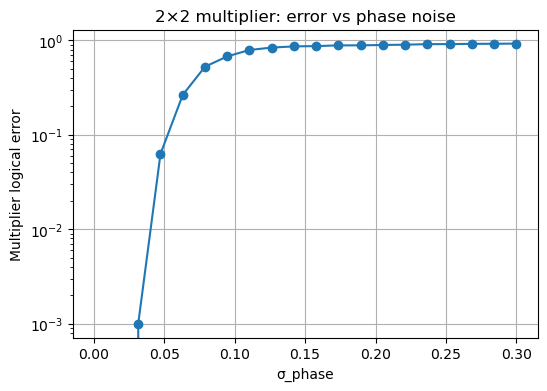

In [53]:
plt.figure(figsize=(6,4))
plt.plot(sigma_phases, err_phase, marker="o")
plt.yscale("log")
plt.xlabel("σ_phase")
plt.ylabel("Multiplier logical error")
plt.title("2×2 multiplier: error vs phase noise")
plt.grid(True)
plt.show()


In [56]:
sigma_trigs = np.linspace(0.278, 3, 20)
err_trig = []

for s in sigma_trigs:
    err = estimate_multiplier_error(
        sigma_phase=SIGMA_PHASE_BASE,
        sigma_trig=s,
        sigma_score=SIGMA_SCORE_BASE,
        p=P_BASE,
        trials=8000,
    )
    err_trig.append(err)
    print(f"sigma_trig={s:.3f}, error={err:.4f}")


sigma_trig=0.278, error=0.0000
sigma_trig=0.421, error=0.0039
sigma_trig=0.565, error=0.0586
sigma_trig=0.708, error=0.1969
sigma_trig=0.851, error=0.3629
sigma_trig=0.994, error=0.5122
sigma_trig=1.138, error=0.6052
sigma_trig=1.281, error=0.6651
sigma_trig=1.424, error=0.7232
sigma_trig=1.567, error=0.7526
sigma_trig=1.711, error=0.7628
sigma_trig=1.854, error=0.7887
sigma_trig=1.997, error=0.7989
sigma_trig=2.140, error=0.8061
sigma_trig=2.284, error=0.8260
sigma_trig=2.427, error=0.8233
sigma_trig=2.570, error=0.8335
sigma_trig=2.713, error=0.8269
sigma_trig=2.857, error=0.8376
sigma_trig=3.000, error=0.8460


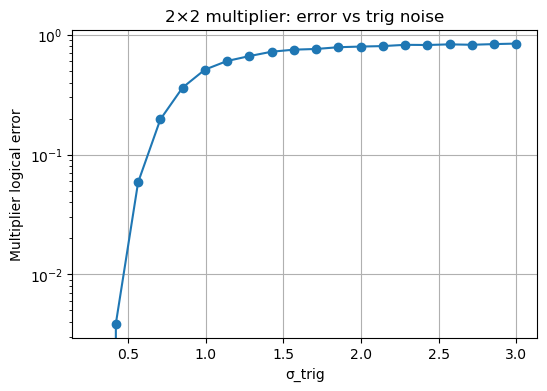

In [57]:
plt.figure(figsize=(6,4))
plt.plot(sigma_trigs, err_trig, marker="o")
plt.yscale("log")
plt.xlabel("σ_trig")
plt.ylabel("Multiplier logical error")
plt.title("2×2 multiplier: error vs trig noise")
plt.grid(True)
plt.show()


In [64]:
sigma_scores = np.linspace(0.633, 8, 20)
err_score = []

for s in sigma_scores:
    err = estimate_multiplier_error(
        sigma_phase=SIGMA_PHASE_BASE,
        sigma_trig=SIGMA_TRIG_BASE,
        sigma_score=s,
        p=P_BASE,
        trials=8000,
    )
    err_score.append(err)
    print(f"sigma_score={s:.3f}, error={err:.4f}")


sigma_score=0.633, error=0.0000
sigma_score=1.021, error=0.0314
sigma_score=1.408, error=0.1976
sigma_score=1.796, error=0.3987
sigma_score=2.184, error=0.5531
sigma_score=2.572, error=0.6325
sigma_score=2.959, error=0.7041
sigma_score=3.347, error=0.7442
sigma_score=3.735, error=0.7796
sigma_score=4.123, error=0.7947
sigma_score=4.510, error=0.8069
sigma_score=4.898, error=0.8187
sigma_score=5.286, error=0.8227
sigma_score=5.674, error=0.8286
sigma_score=6.061, error=0.8370
sigma_score=6.449, error=0.8394
sigma_score=6.837, error=0.8489
sigma_score=7.225, error=0.8494
sigma_score=7.612, error=0.8524
sigma_score=8.000, error=0.8479


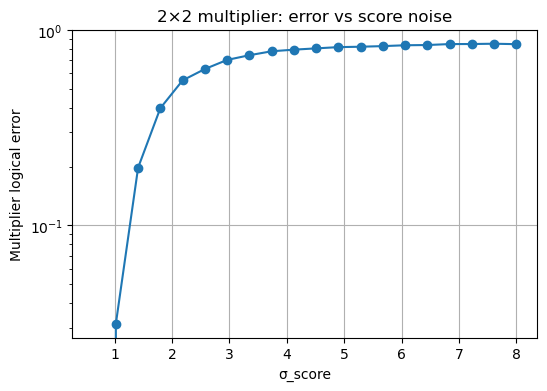

In [65]:
plt.figure(figsize=(6,4))
plt.plot(sigma_scores, err_score, marker="o")
plt.yscale("log")
plt.xlabel("σ_score")
plt.ylabel("Multiplier logical error")
plt.title("2×2 multiplier: error vs score noise")
plt.grid(True)
plt.show()


In [69]:
ps = np.linspace(0.0, 0.5, 20)
err_p = []

for p_val in ps:
    err = estimate_multiplier_error(
        sigma_phase=SIGMA_PHASE_BASE,
        sigma_trig=SIGMA_TRIG_BASE,
        sigma_score=SIGMA_SCORE_BASE,
        p=p_val,
        trials=8000,
    )
    err_p.append(err)
    print(f"p={p_val:.3f}, error={err:.4f}")


p=0.000, error=0.0000
p=0.026, error=0.0391
p=0.053, error=0.1420
p=0.079, error=0.2356
p=0.105, error=0.3266
p=0.132, error=0.3974
p=0.158, error=0.4629
p=0.184, error=0.5005
p=0.211, error=0.5296
p=0.237, error=0.5559
p=0.263, error=0.5604
p=0.289, error=0.5719
p=0.316, error=0.5745
p=0.342, error=0.5811
p=0.368, error=0.5925
p=0.395, error=0.5911
p=0.421, error=0.6016
p=0.447, error=0.5942
p=0.474, error=0.5989
p=0.500, error=0.5985


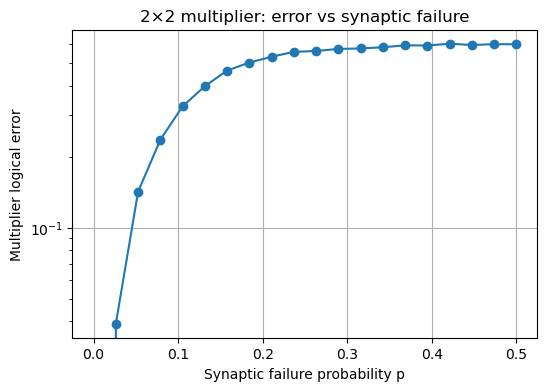

In [70]:
plt.figure(figsize=(6,4))
plt.plot(ps, err_p, marker="o")
plt.yscale("log")
plt.xlabel("Synaptic failure probability p")
plt.ylabel("Multiplier logical error")
plt.title("2×2 multiplier: error vs synaptic failure")
plt.grid(True)
plt.show()


In [13]:
x_values = np.linspace(0.0, 1.0, 11)
encoded_phase_ids = np.linspace(1, M, M, dtype=int)
encoded_phases = (x_values[:, None] / lambdas[None, :]) % 1.0
print(encoded_phases)


[[0.         0.         0.         0.         0.         0.
  0.        ]
 [0.03333333 0.025      0.02       0.01428571 0.00909091 0.00769231
  0.00588235]
 [0.06666667 0.05       0.04       0.02857143 0.01818182 0.01538462
  0.01176471]
 [0.1        0.075      0.06       0.04285714 0.02727273 0.02307692
  0.01764706]
 [0.13333333 0.1        0.08       0.05714286 0.03636364 0.03076923
  0.02352941]
 [0.16666667 0.125      0.1        0.07142857 0.04545455 0.03846154
  0.02941176]
 [0.2        0.15       0.12       0.08571429 0.05454545 0.04615385
  0.03529412]
 [0.23333333 0.175      0.14       0.1        0.06363636 0.05384615
  0.04117647]
 [0.26666667 0.2        0.16       0.11428571 0.07272727 0.06153846
  0.04705882]
 [0.3        0.225      0.18       0.12857143 0.08181818 0.06923077
  0.05294118]
 [0.33333333 0.25       0.2        0.14285714 0.09090909 0.07692308
  0.05882353]]
